### Clustering results
This notebook outlines the workflow to asses consistency of unsupervised clustering across modalites based on autoencoder representations, and the relationship of such unsupervised clustering with established transcriptomic celltypes.
 - GMM fit to the training set to obtain `cluster labels`
 - Cross modal consistency check based on `cluster labels`
 - Agreement of the `cluster labels` with cell type annotations of the Patchseq dataset
 
Variability in the clustering results can be attributed to:
 - Network training (e.g. weight initialization)
 - Particular samples in the validation set (especially in presence of class imbalance)
 - Convergence of GMM fitting
 
Default parameters for network training and choice of parameters here are close to what was used to produce results in the manuscript.

#### 1. Load a trained model + obtain representations ($z_t$ and $z_e$) for all cells

In [1]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

In [2]:
import tensorflow as tf
import scipy.io as sio
from sklearn import mixture

from utils.dataset import load_bioarxiv_dataset,partitions
from model import Model_TE_aug_decoders, custom_build

In [3]:
cvfold=0

D = load_bioarxiv_dataset('../data/proc/')
XT = D['T_dat']
XE = D['E_pcipfx']
XE[np.isnan(XE)] = 0.0

ind_dict = partitions(D['cluster'], n_partitions=40, seed=0)
train_ind,val_ind = ind_dict[cvfold]['train'],ind_dict[cvfold]['val']

T_dim = XT.shape[1]
E_dim = XE.shape[1]

In [4]:
#Load and build model
cplAE = Model_TE_aug_decoders(T_dim,E_dim)
cplAE = custom_build(cplAE,(T_dim,E_dim))
cplAE.train_T=False
cplAE.train_E=False

#Load pre-trained network weights (default settings of train.py)
cplAE.load_weights('../data/pretrained_models/cplAE_aT_1-0_aE_1-0_cs_1-0_ad_1_ld_3_bs_200_se_500_ne_1500_cv_0_ri_0-weights.h5')

In [5]:
#Use only the pre-trained encoders to get representation
zT = cplAE.encoder_T(tf.constant(XT,dtype=tf.float32),training=False)
zE = cplAE.encoder_E(tf.constant(XE,dtype=tf.float32),training=False)

zT = zT.numpy()
zE = zE.numpy()

#### 2. Fit a GMM using only the cells used to train the coupled autoencoder

In [6]:
#GMM fit parameters
n_init = 50
max_iter = int(1e4)
tol = 1e-6
n_components = 33

gmm = mixture.GaussianMixture(n_components=n_components,
                                covariance_type='full',reg_covar=1e-04,
                                tol=tol,max_iter=max_iter,n_init=n_init,
                                init_params='kmeans',
                                random_state=None,
                                warm_start=False,
                                verbose=0)

In [7]:
#Fit gmm
gmm.fit(zT[train_ind,:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=10000,
                means_init=None, n_components=33, n_init=50,
                precisions_init=None, random_state=None, reg_covar=0.0001,
                tol=1e-06, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [8]:
zT_labels = gmm.predict(zT)
zE_labels = gmm.predict(zE)

#### 3. Order GMM components based on correspondence with transcriptomic cell types
 - Transcriptomic ell types are organized as per the reference hierarchy.
 - The correpondence is based on an assignment problem solved using the Hungarian algorithm

In [9]:
from scipy.optimize import linear_sum_assignment
from utils.tree_helpers import get_merged_ordered_classes
from utils.plots import contingency, matrix_scatterplot
%matplotlib inline

In [10]:
#Load reference cell types
n_required_classes = np.unique(D['cluster']).size
t_type_labels,t_types = get_merged_ordered_classes(data_labels=D['cluster'].copy(),
                                                   n_required_classes=n_required_classes)

#t-types that are well-sampled. 
min_sample_thr=10
t_types_well_sampled = []
t_types_poorly_sampled = []
for t in t_types:
    if np.sum(D['cluster']==t)>min_sample_thr:
        t_types_well_sampled.append(t)
    else:
        t_types_poorly_sampled.append(t)
        
#discard train_ind and val_ind for samples that belong to the poorly sampled types
del_ind = np.flatnonzero(np.isin(D['cluster'][train_ind],t_types_poorly_sampled))
train_ind = np.delete(train_ind,del_ind)

del_ind = np.flatnonzero(np.isin(D['cluster'][val_ind],t_types_poorly_sampled))
val_ind = np.delete(val_ind,del_ind)

Performed 0 merges. Remaining classes in data = 59


In [11]:
#Calculate contingency matrix based on gmm cluster labels, and celltype annotations for the training set. Only well-sampled t-types are considered
C_t_types = contingency(a=t_type_labels.copy()[train_ind],
              b=zT_labels[train_ind],
              unique_a=t_types_well_sampled,
              unique_b=np.arange(n_components))

In [12]:
#Assign labels of clusters based on 'best match' with transcriptomic celltype label
row_ind,col_ind = linear_sum_assignment(-C_t_types)

C_ordered = C_t_types[:,col_ind]
order_y = np.arange(0,n_components)[col_ind]

zT_labels_matched = zT_labels.copy()
zE_labels_matched = zE_labels.copy()

for i in range(n_components):
    ind = zT_labels == order_y[i]
    zT_labels_matched[ind] = i

    ind = zE_labels == order_y[i]
    zE_labels_matched[ind] = i

#### 4. Consistency of unsupervised label assignment for the T and E modalities
- `train_ind`: These samples were used to train the coupled autoencoder as well as to fit the GMM.
 - `val_ind`: These samples were neither used in training the coupled autoencoder, nor in fitting the GMM.

**Note:** The scale factor in `matrix_scatterplot` is used for visibility of dots. 

**Consistency of unsupervised labels for validation samples**

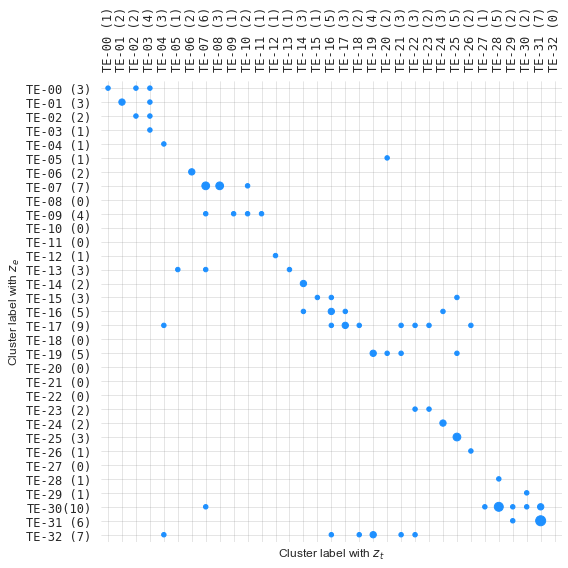

In [13]:
C_TE_consistency = contingency(a=zE_labels_matched[val_ind],
                b=zT_labels_matched[val_ind],
                unique_a=np.arange(n_components),
                unique_b=np.arange(n_components))

ax_xticklabels = ['TE-{:02d}{:>4s}'.format(x,'({:d})'.format(np.sum(zT_labels_matched[val_ind]==x))) for x in np.arange(n_components)]
ax_yticklabels = ['TE-{:02d}{:>4s}'.format(y,'({:d})'.format(np.sum(zE_labels_matched[val_ind]==y))) for y in np.arange(n_components)]
matrix_scatterplot(M=C_TE_consistency,scale_factor=20,
                   xticklabels=ax_xticklabels,
                   yticklabels=ax_yticklabels,
                   xlabel=r'Cluster label with $z_t$',
                   ylabel=r'Cluster label with $z_e$',
                   fig_width=8,fig_height=8)

**Consistency of unsupervised labels for all the samples**

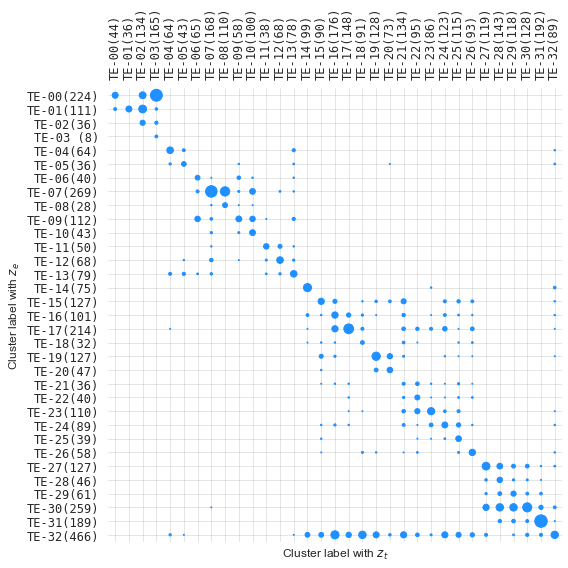

In [14]:
C_TE_consistency = contingency(a=zE_labels_matched,
                b=zT_labels_matched,
                unique_a=np.arange(n_components),
                unique_b=np.arange(n_components))

ax_xticklabels = ['TE-{:02d}{:>4s}'.format(x,'({:d})'.format(np.sum(zT_labels_matched==x))) for x in np.arange(n_components)]
ax_yticklabels = ['TE-{:02d}{:>4s}'.format(y,'({:d})'.format(np.sum(zE_labels_matched==y))) for y in np.arange(n_components)]
matrix_scatterplot(M=C_TE_consistency,scale_factor=1,
                   xticklabels=ax_xticklabels,
                   yticklabels=ax_yticklabels,
                   xlabel=r'Cluster label with $z_t$',
                   ylabel=r'Cluster label with $z_e$',
                   fig_width=8,fig_height=8)

**Relationship of unsupervised labels with t-type annotations for validation samples**

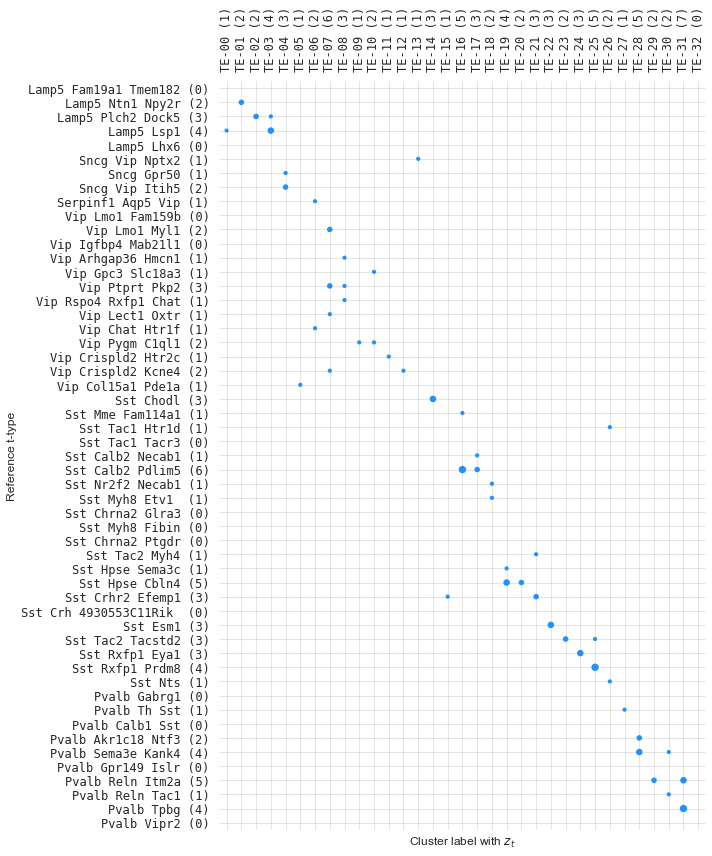

In [15]:
C_t_types = contingency(a=t_type_labels.copy()[val_ind],
              b=zT_labels_matched[val_ind],
              unique_a=t_types_well_sampled,
              unique_b=np.arange(n_components))

ax_xticklabels = ['TE-{:02d}{:>4s}'.format(x,'({:d})'.format(np.sum(zT_labels_matched[val_ind]==x))) for x in np.arange(n_components)]
ax_yticklabels = ['{} ({:d})'.format(y,np.sum(D['cluster'][val_ind]==y)) for y in t_types_well_sampled]

matrix_scatterplot(M=C_t_types,scale_factor=10,
                xticklabels=ax_xticklabels,
                yticklabels=ax_yticklabels,
                xlabel=r'Cluster label with $z_t$',
                ylabel=r'Reference t-type',
                fig_width=10,fig_height=12)

**Relationship of unsupervised labels with t-type annotations for all samples**

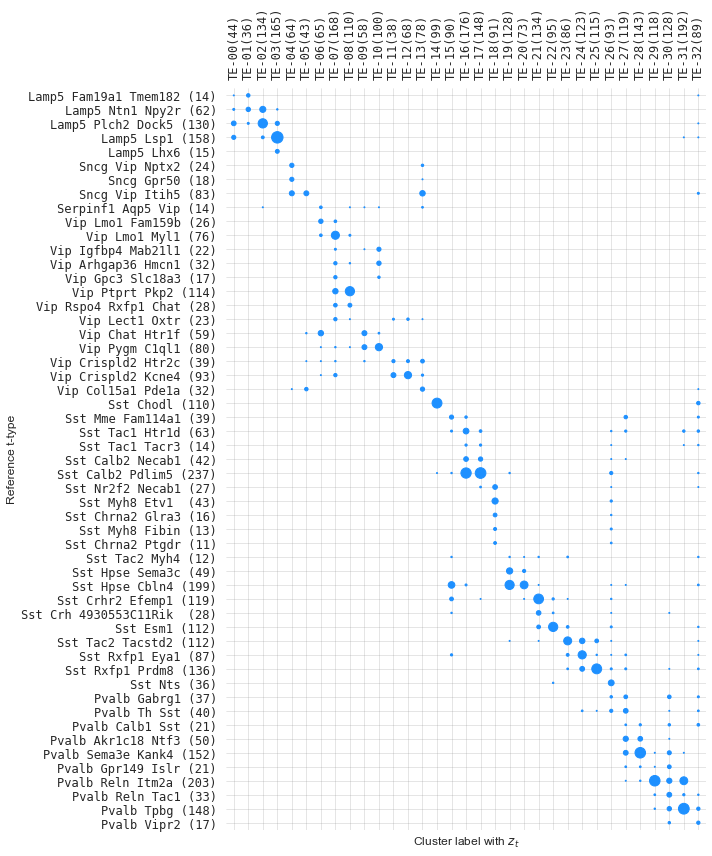

In [16]:
C_t_types = contingency(a=t_type_labels.copy(),
              b=zT_labels_matched,
              unique_a=t_types_well_sampled,
              unique_b=np.arange(n_components))

ax_xticklabels = ['TE-{:02d}{:>4s}'.format(x,'({:d})'.format(np.sum(zT_labels_matched==x))) for x in np.arange(n_components)]
ax_yticklabels = ['{} ({:d})'.format(y,np.sum(D['cluster']==y)) for y in t_types_well_sampled]

matrix_scatterplot(M=C_t_types,scale_factor=1,
                xticklabels=ax_xticklabels,
                yticklabels=ax_yticklabels,
                xlabel=r'Cluster label with $z_t$',
                ylabel=r'Reference t-type',
                fig_width=10,fig_height=12)